# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Open a Japanese Restaurant in New York City



## Introduction <a name="introduction"></a>

New York City (NYC), often called simply New York, is the most populous city in the United States. With an estimated 2019 population of 8,336,817 distributed over about 302.6 square miles, New York City is also the most densely populated major city in the United States. Located at the southern tip of the State of New York, the city is the center of the New York metropolitan area, the largest metropolitan area in the world by urban landmass. With almost 20 million people in its metropolitan statistical area and approximately 23 million in its combined statistical area, it is one of the world's most populous megacities. New York City has been described as the cultural, financial, and media capital of the world, significantly influencing commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports. Home to the headquarters of the United Nations, New York is an important center for international diplomacy and has sometimes been nicknamed the "Capital of the World".

This project explores the best locations for Japanese restaurants throughout the New York City. Japanese restaurants became highly popular, as with any business, opening a new restaurant requires serious considerations and is more complicated than it seems from the first glance. 

In particular, the location of the restaurant is one of the most important factors that will affect whether it will have success or a failure. Therefore, this project would answer the questions "If someone is looking to open a new Japanese restaurant in the New York City, where is the best area for opening a new Japanese Restaurant?"

## Data <a name="data"></a>

•	New York City data containing the neighborhoods and boroughs. 

•	Venue data, particularly data related to restaurants.

•	Latitude and longitude of those neighborhoods.

New York City data containing the neighborhoods and boroughs will be obtained from the open data source: https://cocl.us/new_york_dataset.


## Methodology

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Japanese restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings.

• Finally, the data be will be visually assessed using graphing from Python libraries.

## Problem

1. Where is the best location for Japanese restaurant in New York City?
2. In what Neighborhood and/or borough should the investor open a Japanese restaurant to have the best chance of being successful?

## Import all required libraries

In [1]:
import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

!pip install folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 7.5 MB/s  eta 0:00:01
Libraries imported.


## Define Foursquare Credentials and Version

In [2]:
CLIENT_ID = '0T3O1AEYMQWDGVPWIT0KN3WFKPAKTBWAWXHCJDYUQPH1YUYX' # your Foursquare ID
CLIENT_SECRET = 'B51F5WOJQOUC3CWWHP3H2J2HMYEAXJQ3DEK0CB0KW3SDTHGN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Define the functions

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_data.shape

(306, 4)

#### There are 306 different Neighborhoods in New York.

## Analyze data.

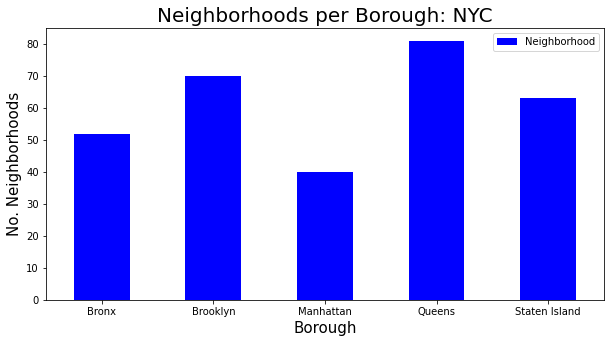

In [6]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

## Analyze further and see how many Japanese restaurants in each neighborhood and borough. Then graph the results.

In [7]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

In [8]:
#japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')

In [9]:
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
60,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
61,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
62,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
63,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
64,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou


In [10]:
japanese_rest_ny.shape

(65, 4)

#### There are 65 Japanese Restaurants across the New York City.

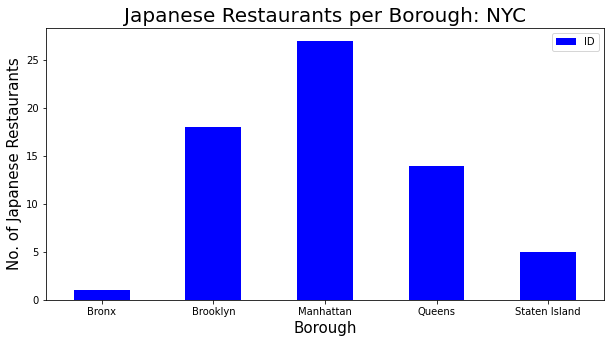

In [11]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

#### Manhattan have the highest number of Japanese restaurants.

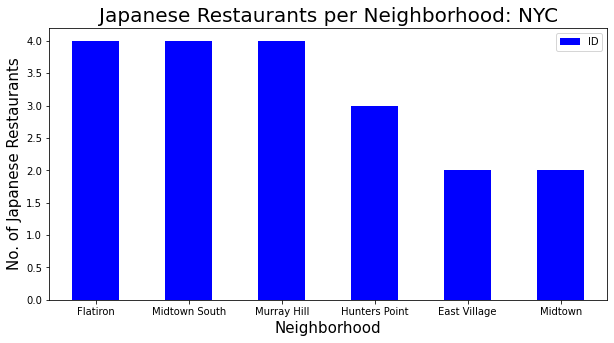

In [12]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

#### This is the top 6 neighborhoods, Flatiron has the highest number of Japanese restaurants in New York City.

####  Now we will get the ranking of each restaurant for further analysis.

In [13]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Flatiron']

,Borough,Neighborhood,ID,Name
59,Manhattan,Flatiron,4f7b61f6e4b07aaa5d524842,OOTOYA 大戸屋 (OOTOYA)
60,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
61,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
62,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago


In [14]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '606db00325fa6e064b9b5b8d'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49}, 'url': 'http

KeyError: 'venue'

In [15]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [16]:
japanese_rest_stats_ny.shape

(50, 7)

#### There are 50 Japanese Restaurants in New York city.

#### Next step we will check what values we have in our DataFrame

In [17]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [18]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [19]:
japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.0000,50.000000,50.000000
mean,136.7200,7.922000,41.140000
std,220.3174,1.359365,59.698566
min,0.0000,0.000000,0.000000
25%,17.0000,7.675000,6.000000
50%,48.5000,8.200000,15.000000
75%,139.7500,8.575000,48.250000
max,1054.0000,9.400000,266.000000


#### Resturant with maximum Likes

In [20]:
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1054
Rating                               8.8
Tips                                 266
Name: 47, dtype: object

#### Resturant with maximum Ratings

In [21]:
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              5b3805910dd31f002409405a
Name                          Suki Curry
Likes                                 57
Rating                               9.4
Tips                                  15
Name: 27, dtype: object

#### Resturant with maximum Tips

In [22]:
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1054
Rating                               8.8
Tips                                 266
Name: 47, dtype: object

#### Next step we will identify and visualize neighborhood with the maximum average rating of restaurants

In [23]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
10,East Village,9.35
8,Cobble Hill,9.10
30,Park Slope,9.00
29,North Side,8.90
9,Downtown,8.90
1,Boerum Hill,8.80
22,Lindenwood,8.70
34,Soho,8.70
11,Fort Greene,8.60
36,Upper East Side,8.50


#### There are the top neighborhoods with the highest average ratings of Japanese restaurants.

In [24]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Brooklyn,8.360000
1,Manhattan,8.352381
3,Staten Island,7.080000
2,Queens,6.655556


#### These are the average ratings of Japanese Restaurants for each Borough

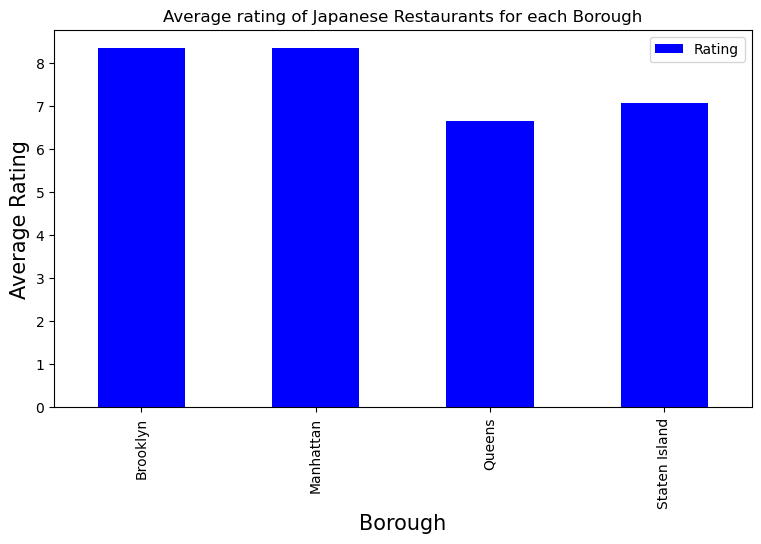

In [25]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

#### We will consider all the neighborhoods with average rating greater or equal 6.0 to visualize on a map

In [33]:
y_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=6]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.400
1,Boerum Hill,8.800
2,Brooklyn Heights,8.100
3,Bulls Head,7.200
4,Carroll Gardens,8.300
5,Castleton Corners,6.200
6,Chinatown,7.600
7,Clinton Hill,7.000
8,Cobble Hill,9.100
9,Downtown,8.900


#### We will join this Dataset to original New York data to get longitude and latitude

In [34]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.400
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.800
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.100
3,Staten Island,Bulls Head,40.609592,-74.159409,7.200
4,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.300
5,Staten Island,Castleton Corners,40.613336,-74.119181,6.200
6,Manhattan,Chinatown,40.715618,-73.994279,7.600
7,Brooklyn,Clinton Hill,40.693229,-73.967843,7.000
8,Brooklyn,Cobble Hill,40.687920,-73.998561,9.100
9,Brooklyn,Downtown,40.690844,-73.983463,8.900


#### Now we will show this data on a map

In [36]:
import folium
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [37]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Conclusion

#### Brooklyn and Manhattan have the best rated Japanese restaurants. On the other hand, Staten Island and Queens have the least amount of Japanese restaurants per borough. Based on the above information, I would say that Manhattan and Brooklyn are the best locations for Japanese resyaurants in New York City. Recommend to you investor to open a Japanese restaurant in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 7.0 on a scale, making competition easier. In addition, real estate prices in Brooklyn are cheaper than in Manhattan. Finally, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.